# Single-cell RNA-seq analysis workflow using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION. 

Licensed under the Apache License, Version 2.0 (the "License") 
you may not use this file except in compliance with the License. 
You may obtain a copy of the License at 

     http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software 
distributed under the License is distributed on an "AS IS" BASIS, 
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
See the License for the specific language governing permissions and 
limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import scanpy as sc

from sklearn.cluster import KMeans

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/krasnow_hlca_10x_UMIs.sparse.h5ad"

## Set parameters

In [3]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs for t-SNE and k-means
n_jobs=32

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata = adata.T

CPU times: user 1.78 s, sys: 417 ms, total: 2.2 s
Wall time: 2.2 s


## Preprocessing

In [6]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [7]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 1.2 s, sys: 794 ms, total: 2 s
Wall time: 2 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [8]:
%%time
sc.pp.filter_genes(adata, min_cells=1)

CPU times: user 1.4 s, sys: 390 ms, total: 1.79 s
Wall time: 1.79 s


### Normalize

In [9]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 546 ms, sys: 48.6 ms, total: 595 ms
Wall time: 593 ms


In [10]:
%%time
sc.pp.log1p(adata)

CPU times: user 2.01 s, sys: 0 ns, total: 2.01 s
Wall time: 2.01 s


### Select Most Variable Genes

In [11]:
%%time
# Filter matrix to only variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker+"_raw"]= adata.X[:, adata.var.index==marker].todense()

adata = adata.copy()
n_genes = sum(adata.var.highly_variable)
adata = adata[:, adata.var.highly_variable]

CPU times: user 2.97 s, sys: 106 ms, total: 3.08 s
Wall time: 3.07 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

In [12]:
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [13]:
%%time
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_ribo'] = np.array(np.sum(adata[:, ribo_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.53 s, sys: 79.3 ms, total: 1.61 s
Wall time: 1.61 s


In [14]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_ribo'])

CPU times: user 46min 42s, sys: 3h 9min 20s, total: 3h 56min 3s
Wall time: 4min 58s


### Scale

In [15]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.77 s, sys: 174 ms, total: 1.94 s
Wall time: 1.94 s


In [16]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 311.43055295944214


## Cluster & Visualize

### Reduce

In [17]:
%%time
# PCA
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 7min 41s, sys: 5min 10s, total: 12min 52s
Wall time: 17.7 s


### TSNE + K-means

In [18]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, n_jobs=n_jobs)

CPU times: user 18min 17s, sys: 5.22 s, total: 18min 22s
Wall time: 3min 28s


In [19]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

/home/ubuntu/.local/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


CPU times: user 8min 45s, sys: 14min 37s, total: 23min 23s
Wall time: 31.2 s


... storing 'kmeans' as categorical


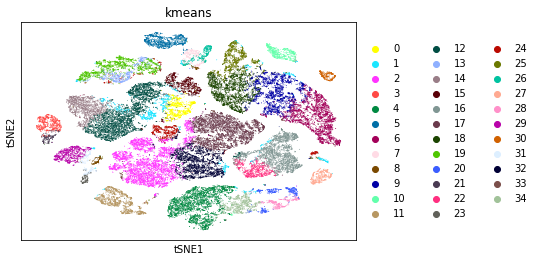

CPU times: user 15.1 s, sys: 95.6 ms, total: 15.2 s
Wall time: 1.59 s


In [20]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

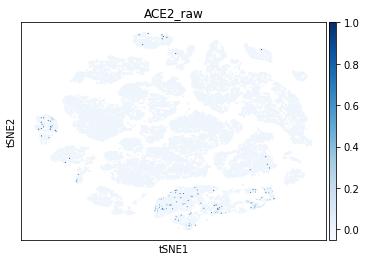

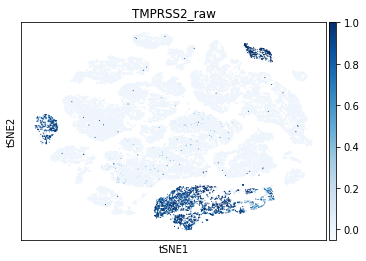

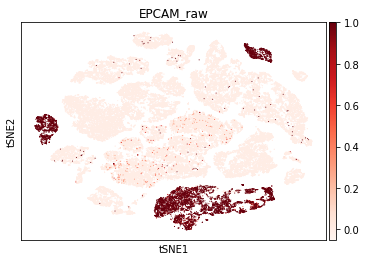

CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.14 s


In [21]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Louvain

In [22]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 24.6 s, sys: 657 ms, total: 25.3 s
Wall time: 25.2 s


In [23]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 7min 32s, sys: 7min 17s, total: 14min 49s
Wall time: 1min 20s


In [24]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 16.8 s, sys: 94.8 ms, total: 16.9 s
Wall time: 16.8 s


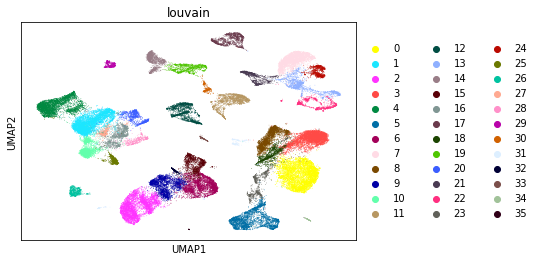

CPU times: user 1.29 s, sys: 4.77 ms, total: 1.3 s
Wall time: 1.3 s


In [25]:
%%time
# Plot
sc.pl.umap(adata, color=["louvain"])

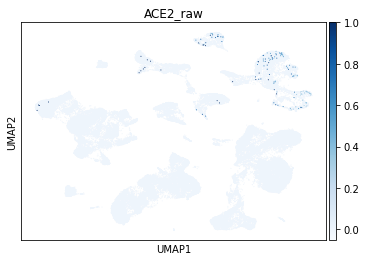

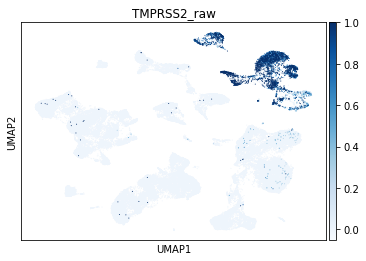

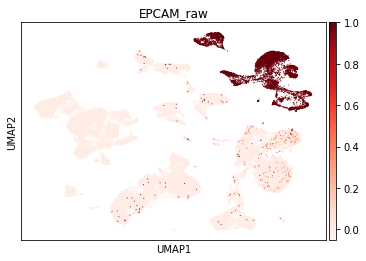

CPU times: user 1.11 s, sys: 17.1 ms, total: 1.13 s
Wall time: 1.12 s


In [26]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

## Differential expression analysis

In [27]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=ranking_n_top_genes, groups='all', reference='rest')

/home/ubuntu/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


CPU times: user 44.2 s, sys: 9.56 s, total: 53.8 s
Wall time: 53.8 s


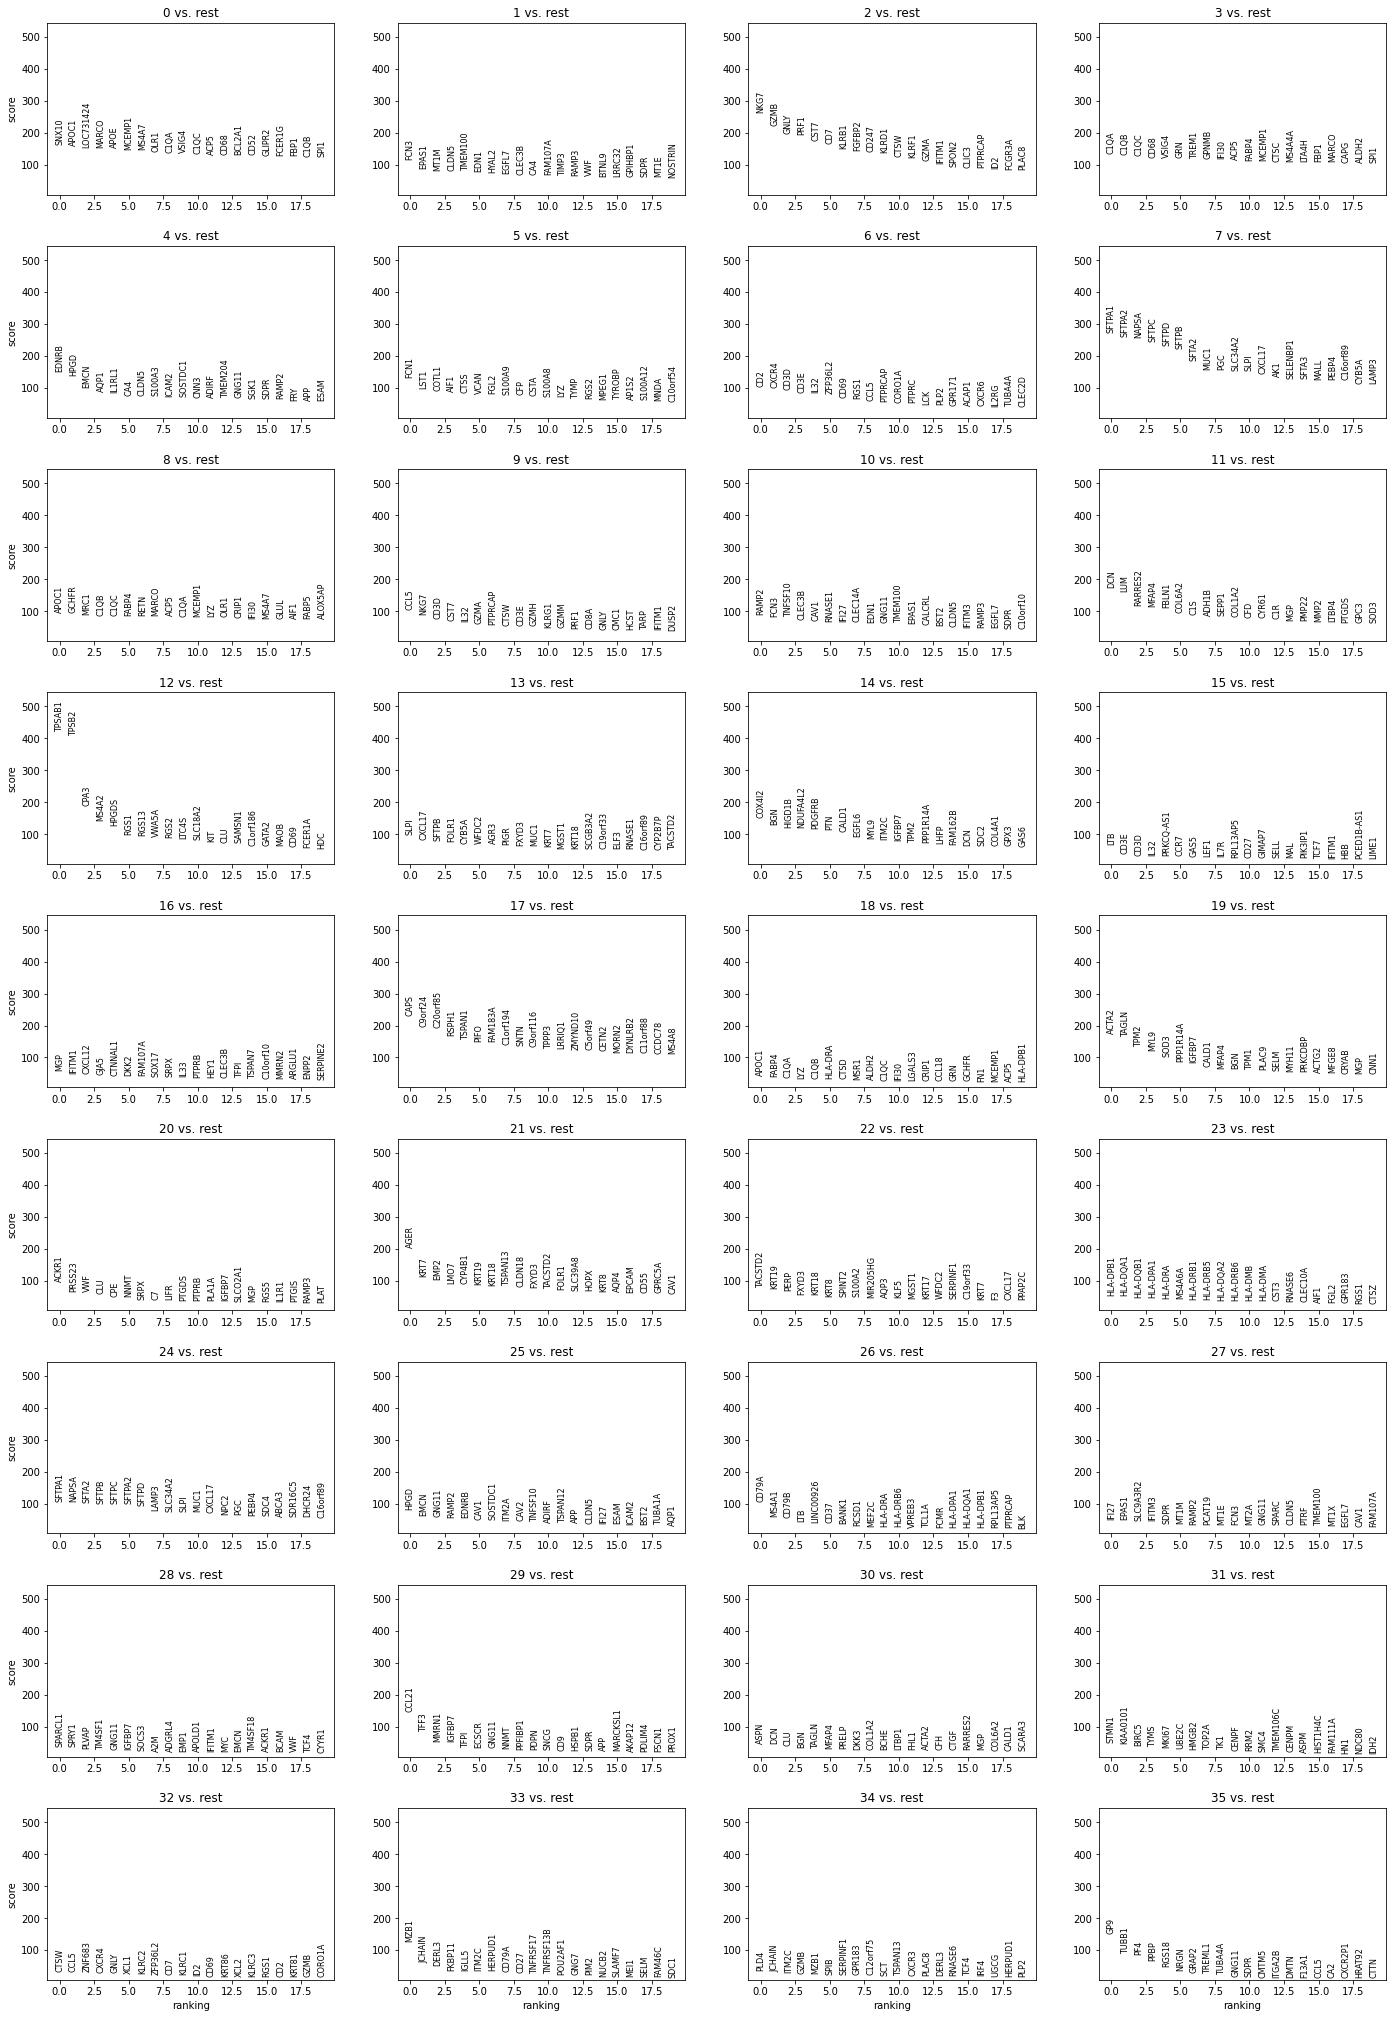

CPU times: user 7.65 s, sys: 381 ms, total: 8.03 s
Wall time: 8.02 s


In [28]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create zoomed-in view

In [29]:
reanalysis_start = time.time()

In [30]:
%%time

adata = adata[adata.obs["EPCAM_raw"] > 0.0, :]
print(adata.X.shape)

(7958, 5000)
CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 103 ms


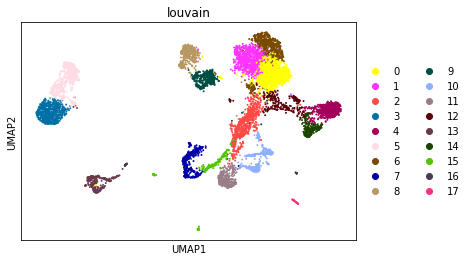

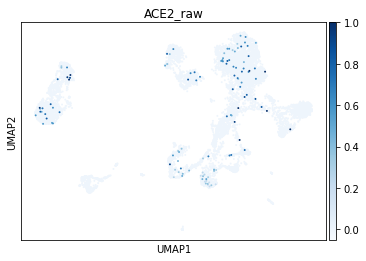

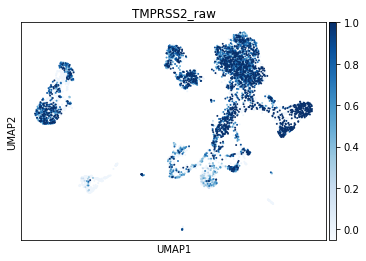

CPU times: user 1min 49s, sys: 2min 9s, total: 3min 59s
Wall time: 26.7 s


In [31]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.louvain(adata)

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [32]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 26.779075145721436


In [33]:
print("Full time: %s" % (time.time() - start))

Full time: 786.8515763282776
